# Jupyter Notebook Shortcuts

In [ ]:
### Execution
# Shift+Enter: Execute cell, move to next cell

### Toggling Command/Edit Mode
# Esc: Edit Mode -> Command Mode
# Enter: Command Mode -> Edit Mode

### While in Command Mode
# A: Create cell ABOVE
# B: Create cell BELOW
# D+D: Delete cell
# M: Switch to Markdown
# Y: Switch to Code
# O: Toggle output show/hide

# Setup

In [334]:
import sys
# !conda install --yes --prefix {sys.prefix} matplotlib
# !conda install --yes --prefix {sys.prefix} -c conda-forge fbprophet
# !conda install --yes --prefix {sys.prefix} xgboost

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.4
  latest version: 4.8.5

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - xgboost

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.




In [1]:
import sqlite3
import pandas as pd
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import fbprophet
from fbprophet import Prophet
import xgboost as xgb

# Jupyter settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

def disp(df, head_lines = 5):
    print(df.shape)
    display(df.head(head_lines))

Importing plotly failed. Interactive plots will not work.


In [10]:
query_rides_a = '''
    SELECT *
    FROM rides_a
'''

query_rides_b = '''
    SELECT *
    FROM rides_b
'''

query_weather = '''
    SELECT *
    FROM weather
'''

In [11]:
conn = sqlite3.connect('msda_workshop')
rides_a_df = pd.read_sql_query(query_rides_a, conn)
rides_b_df = pd.read_sql_query(query_rides_b, conn)
weather_df = pd.read_sql_query(query_weather, conn)
conn.close()

In [15]:
rides_a_df.head()

,RIDE_ID,started_on,created_date,updated_date,completed_on,distance_travelled,end_location_lat,end_location_long,driver_rating,rider_rating,...,charity_id,requested_car_category,free_credit_used,surge_factor,start_location_long,start_location_lat,rider_id,round_up_amount,promocode_redemption_id,driver_reached_on
0,0,2016-06-04 00:18:49-05:00,2016-06-04 00:10:19-05:00,2016-06-04 00:27:48-05:00,2016-06-04 00:27:32-05:00,8459.0,38.676,-121.039,5.0,5.0,...,,b'REGULAR',,0.0,-121.071,38.655,0,,,2016-06-04 00:14:11-05:00
1,1,2016-06-04 01:50:12-05:00,2016-06-04 01:47:39-05:00,2016-06-04 01:52:00-05:00,2016-06-04 01:51:49-05:00,443.0,38.676,-121.039,5.0,5.0,...,,b'REGULAR',,0.0,-121.038,38.679,0,,,2016-06-04 01:50:02-05:00
2,2,2016-06-04 03:16:02-05:00,2016-06-04 03:13:07-05:00,2016-06-04 03:18:07-05:00,2016-06-04 03:17:57-05:00,568.0,38.676,-121.039,3.0,5.0,...,,b'REGULAR',,0.0,-121.042,38.678,0,,,2016-06-04 03:16:01-05:00
3,3,2016-06-04 10:05:13-05:00,2016-06-04 09:52:35-05:00,2016-06-04 10:14:00-05:00,2016-06-04 10:13:38-05:00,4051.0,30.271,-97.742,5.0,5.0,...,,b'REGULAR',,0.0,-97.764,30.247,1,,,2016-06-04 10:01:19-05:00
4,4,2016-06-04 10:24:25-05:00,2016-06-04 10:23:25-05:00,2016-06-04 10:26:16-05:00,2016-06-04 10:26:07-05:00,790.0,30.269,-97.752,5.0,5.0,...,,b'REGULAR',,0.0,-97.75,30.269,2,,,2016-06-04 10:24:15-05:00


In [13]:
rides_b_df.head()

,RIDE_ID,base_fare,total_fare,rate_per_mile,rate_per_minute,time_fare,driver_accepted_on,esimtated_time_arrive,tipped_on,tip,...,dispatched_on,status,driver_id,car_id,color,make,model,year,car_categories_bitmask,rating
0,0,1.5,25.84,1.5,0.25,2.18,,,,,...,2016-06-04 05:10:19,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
1,1,1.5,5.0,1.5,0.25,0.41,,,,,...,2016-06-04 06:47:39,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
2,2,1.5,5.0,1.5,0.25,0.48,,,,,...,2016-06-04 08:13:07,b'DISPATCHED',0,0,b'Gray',b'Bentley',b'Continental GT',b'2013',1,5.0
3,3,1.5,8.93,1.5,0.25,2.11,,,,,...,2016-06-04 14:52:35,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0
4,4,1.5,5.0,1.5,0.25,0.43,,,,,...,2016-06-04 15:23:25,b'DISPATCHED',1,1,b'Black',b'Cadillac',b'XTS',b'2013',21,5.0


In [14]:
weather_df.head()

,RIDE_ID,HOURLYVISIBILITY,HOURLYDRYBULBTEMPC,HOURLYRelativeHumidity,HOURLYWindSpeed,HOURLYWindDirection,HOURLYPrecip,DAILYMaximumDryBulbTemp,DAILYMinimumDryBulbTemp,DAILYDeptFromNormalAverageTemp,DAILYAverageRelativeHumidity,DAILYSunrise,DAILYSunset,DAILYPrecip,DAILYAverageWindSpeed,DAILYPeakWindSpeed
0,0,8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


In [128]:
start_time = time.time()

query_rides = '''
    SELECT
         a.RIDE_ID                      AS ride_id
        ,DATE(created_date)             AS date
        ,distance_travelled             AS distance
        ,start_location_lat             AS start_lat
        ,start_location_long            AS start_long
        ,end_location_lat               AS end_lat
        ,end_location_long              AS end_long
        ,round_up_amount                AS charity_amount
        ,status                         AS status
        ,requested_car_category         AS car_category
        ,make                           AS car_make
        ,model                          AS car_model
        ,HOURLYVISIBILITY               AS hourly_visibility
        ,HOURLYDRYBULBTEMPC             AS hourly_temp
        ,HOURLYRelativeHumidity         AS hourly_humidity
        ,HOURLYWindSpeed                AS hourly_wind_speed
        ,HOURLYWindDirection            AS hourly_wind_direction
        ,HOURLYPrecip                   AS hourly_precip
        ,DAILYMaximumDryBulbTemp        AS daily_temp_max
        ,DAILYMinimumDryBulbTemp        AS daily_temp_min
        ,DAILYDeptFromNormalAverageTemp AS daily_temp_departure
        ,DAILYAverageRelativeHumidity   AS daily_humidity
        ,DAILYSunrise                   AS daily_sunrise
        ,DAILYSunset                    AS daily_sunset
        ,DAILYPrecip                    AS daily_precip
        ,DAILYAverageWindSpeed          AS daily_wind_speed_avg
        ,DAILYPeakWindSpeed             AS daily_wind_spead_peak
    FROM rides_a a
        INNER JOIN rides_b b
            ON a.RIDE_ID = b.RIDE_ID
        INNER JOIN weather w
            ON a.RIDE_ID = w.RIDE_ID
'''

conn = sqlite3.connect('msda_workshop')
# rides_df = pd.read_sql_query(query_rides, conn)
rides_df = pd.read_sql_query(query_rides, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1494125, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,,,,,529.0,1930.0,1.63,,
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,,,,,529.0,1930.0,,,
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,,,,,529.0,1930.0,,,
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,,,,,529.0,1930.0,,,


36.725362062454224


In [ ]:
yyyy-mm-dd hh:mm:ss-hh:mm

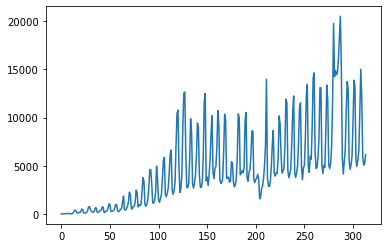

In [41]:
days_df['rides'].plot()

In [25]:
df.columns

Index(['RIDE_ID', 'started_on', 'created_date', 'updated_date', 'completed_on', 'distance_travelled', 'end_location_lat', 'end_location_long', 'driver_rating', 'rider_rating', 'active_driver_id', 'charity_id', 'requested_car_category', 'free_credit_used', 'surge_factor', 'start_location_long', 'start_location_lat', 'rider_id', 'round_up_amount', 'promocode_redemption_id', 'driver_reached_on', 'RIDE_ID', 'base_fare', 'total_fare', 'rate_per_mile', 'rate_per_minute', 'time_fare', 'driver_accepted_on', 'esimtated_time_arrive', 'tipped_on', 'tip', 'driving_time_to_rider', 'dispatch_location_lat', 'dispatch_location_long', 'driving_distance_to_rider', 'dispatched_on', 'status', 'driver_id', 'car_id', 'color', 'make', 'model', 'year', 'car_categories_bitmask', 'rating', 'RIDE_ID', 'HOURLYVISIBILITY', 'HOURLYDRYBULBTEMPC', 'HOURLYRelativeHumidity', 'HOURLYWindSpeed', 'HOURLYWindDirection', 'HOURLYPrecip', 'DAILYMaximumDryBulbTemp', 'DAILYMinimumDryBulbTemp', 'DAILYDeptFromNormalAverageTemp',


In [130]:
rides_df['car_category'].value_counts()

b'REGULAR'    1419521
b'SUV'          54784
b'PREMIUM'      13967
b'LUXURY'        4340
b'HONDA'         1513
Name: car_category, dtype: int64

# Preprocessing

In [132]:
# Turn empty strings to NULLs
num_cols = [col for col in rides_df.columns if 'daily' in col]
for col in num_cols:
    rides_df.loc[rides_df[col] == '', col] = np.nan

In [133]:
disp(rides_df)

(1494125, 27)


,ride_id,date,distance,start_lat,start_long,end_lat,end_long,charity_amount,status,car_category,car_make,car_model,hourly_visibility,hourly_temp,hourly_humidity,hourly_wind_speed,hourly_wind_direction,hourly_precip,daily_temp_max,daily_temp_min,daily_temp_departure,daily_humidity,daily_sunrise,daily_sunset,daily_precip,daily_wind_speed_avg,daily_wind_spead_peak
0,0,2016-06-04,8459.0,38.655,-121.071,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',8.75,20.700000000000003,94.0,6.0,13.333333333333334,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,1.63,NaN,NaN
1,1,2016-06-04,443.0,38.679,-121.038,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',6.0,21.1,93.0,1.5,0.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
2,2,2016-06-04,568.0,38.678,-121.042,38.676,-121.039,,b'DISPATCHED',b'REGULAR',b'Bentley',b'Continental GT',10.0,23.03333333333333,88.0,5.0,350.0,,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
3,3,2016-06-04,4051.0,30.247,-97.764,30.271,-97.742,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN
4,4,2016-06-04,790.0,30.269,-97.75,30.269,-97.752,,b'DISPATCHED',b'REGULAR',b'Cadillac',b'XTS',10.0,26.7,64.0,11.0,360.0,0.0,NaN,NaN,NaN,NaN,529.0,1930.0,NaN,NaN,NaN


In [134]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494125 entries, 0 to 1494124
Data columns (total 27 columns):
 #   Column                 Non-Null Count    Dtype 
---  ------                 --------------    ----- 
 0   ride_id                1494125 non-null  object
 1   date                   1494125 non-null  object
 2   distance               1494125 non-null  object
 3   start_lat              1494125 non-null  object
 4   start_long             1494125 non-null  object
 5   end_lat                1494125 non-null  object
 6   end_long               1494125 non-null  object
 7   charity_amount         1494125 non-null  object
 8   status                 1494125 non-null  object
 9   car_category           1494125 non-null  object
 10  car_make               1494125 non-null  object
 11  car_model              1494125 non-null  object
 12  hourly_visibility      1494125 non-null  object
 13  hourly_temp            1494125 non-null  object
 14  hourly_humidity        1494125 non

In [164]:
start_time = time.time()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                      AS ride_id
            ,DATE(created_date)             AS date
            ,SUBSTR(created_date, 11, 2)    AS hour
            ,distance_travelled             AS distance
            ,start_location_lat             AS start_lat
            ,start_location_long            AS start_long
            ,end_location_lat               AS end_lat
            ,end_location_long              AS end_long
            ,round_up_amount                AS charity_amount
            ,status                         AS status
            ,requested_car_category         AS car_category
            ,make                           AS car_make
            ,model                          AS car_model
            ,HOURLYVISIBILITY               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC             AS hourly_temp
            ,HOURLYRelativeHumidity         AS hourly_humidity
            ,HOURLYWindSpeed                AS hourly_wind_speed
            ,HOURLYWindDirection            AS hourly_wind_direction
            ,HOURLYPrecip                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1494125, 9)


,date,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,2016-06-04,8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,2016-06-04,443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2016-06-04,568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,2016-06-04,4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,2016-06-04,790.0,,9.375,26.7,26.7,79.0,8.5,0.0


24.88865375518799


In [136]:
rides_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1494125 entries, 0 to 1494124
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   date              1494125 non-null  object 
 1   distance          1494125 non-null  object 
 2   charity_amount    1494125 non-null  object 
 3   daily_visibility  1494125 non-null  float64
 4   daily_temp_max    1494125 non-null  object 
 5   daily_temp_min    1494125 non-null  object 
 6   daily_humidity    1494125 non-null  float64
 7   daily_wind_speed  1494125 non-null  float64
 8   daily_precip      1494125 non-null  float64
dtypes: float64(4), object(5)
memory usage: 102.6+ MB


In [137]:
rides_df['date'][0]

'2016-06-04'

In [145]:
rides_df['charity_amount'].replace('', '0').astype(float).unique()

array([0.  , 0.31, 0.74, 0.75, 0.03, 0.28, 0.04, 0.07, 0.66, 0.93, 0.95,
       0.79, 0.29, 0.88, 0.25, 0.98, 0.47, 0.43, 0.17, 0.37, 0.91, 0.65,
       0.64, 0.99, 0.26, 0.59, 0.11, 0.15, 0.1 , 0.01, 0.58, 0.24, 0.18,
       0.71, 0.36, 0.02, 0.85, 0.78, 0.22, 0.82, 0.72, 0.4 , 0.41, 0.87,
       0.06, 0.44, 0.2 , 0.35, 0.14, 0.97, 0.6 , 0.56, 0.53, 0.62, 0.86,
       0.27, 0.7 , 0.84, 0.19, 0.81, 0.13, 0.23, 0.76, 0.89, 0.5 , 0.77,
       0.8 , 0.83, 0.16, 0.49, 0.92, 0.12, 0.9 , 0.39, 0.94, 0.42, 0.08,
       0.61, 0.45, 0.51, 0.33, 0.34, 0.46, 0.96, 0.48, 0.73, 0.57, 0.54,
       0.68, 0.05, 0.55, 0.67, 0.38, 0.52, 0.63, 0.32, 0.21, 0.09, 0.69,
       0.3 ])

In [165]:
# Preprocessing
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

rides_df['date'] = pd.to_datetime(rides_df['date']).dt.date
rides_df['distance'] = rides_df['distance'].replace('', '0').astype(float)
rides_df['charity_amount'] = rides_df['charity_amount'].replace('', '0').astype(float)
rides_df['daily_temp_max'] = rides_df['daily_temp_max'].astype(float)
rides_df['daily_temp_min'] = rides_df['daily_temp_min'].astype(float)
rides_df['daily_temp_max_f'] = rides_df['daily_temp_max'].apply(celsius_to_fahrenheit)
rides_df['daily_temp_min_f'] = rides_df['daily_temp_min'].apply(celsius_to_fahrenheit)

In [166]:
days_df = rides_df.groupby(['date']).agg(
    rides = ('date', 'count'),
    distance = ('distance', 'sum'),
    charity_amount = ('charity_amount', 'sum'),
    visibility = ('daily_visibility', 'max'),
    temp_max = ('daily_temp_max_f', 'max'),
    temp_min = ('daily_temp_min_f', 'max'),
    humidity = ('daily_humidity', 'max'),
    wind_speed = ('daily_wind_speed', 'max'),
    precip = ('daily_precip', 'max')
).reset_index()

disp(days_df)

(314, 10)


,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,2016-06-04,5,14311.0,0.0,9.375000,80.06,80.06,79.000000,8.500000,0.0
1,2016-06-05,13,75814.0,0.0,10.000000,77.00,69.98,77.666667,5.000000,0.0
2,2016-06-06,20,95260.0,0.0,10.000000,89.06,71.96,59.333333,6.333333,0.0
3,2016-06-07,21,154710.0,0.0,10.000000,91.04,69.98,70.666667,3.333333,0.0
4,2016-06-08,36,214613.0,0.0,9.666667,91.04,73.04,76.333333,5.000000,0.0


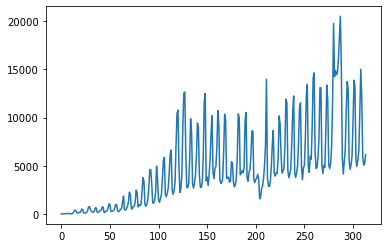

In [167]:
days_df['rides'].plot()

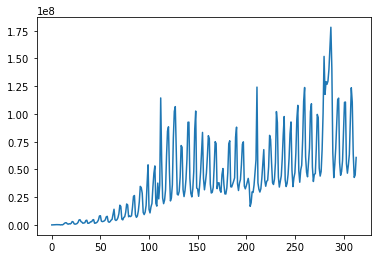

In [168]:
days_df['distance'].plot()

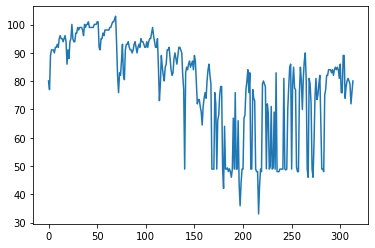

In [169]:
days_df['temp_max'].plot()

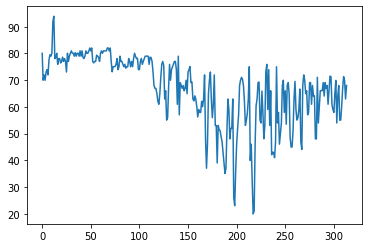

In [170]:
days_df['temp_min'].plot()

In [162]:
print(f"Start Date: {days_df['date'].min()}")
print(f"End Date: {days_df['date'].max()}")

Start Date: 2016-06-04
End Date: 2017-04-13


# Once initial preprocessing code written, add status/car_category to data

In [2]:
# CHANGES:
# Added case statement for car_category
# Added filters for car_category and status
# Added car_category to final query

start_time = time.time()

query = '''
    WITH rides AS (
        SELECT
             a.RIDE_ID                                      AS ride_id
            ,DATE(created_date)                             AS date
            ,SUBSTR(created_date, 11, 2)                    AS hour
            ,distance_travelled                             AS distance
            ,start_location_lat                             AS start_lat
            ,start_location_long                            AS start_long
            ,end_location_lat                               AS end_lat
            ,end_location_long                              AS end_long
            ,round_up_amount                                AS charity_amount
            ,(CASE
                WHEN requested_car_category = "b'LUXURY'"
                    THEN "b'PREMIUM'"
                ELSE requested_car_category
              END)                                          AS car_category
            ,make                                           AS car_make
            ,model                                          AS car_model
            ,HOURLYVISIBILITY                               AS hourly_visibility
            ,HOURLYDRYBULBTEMPC                             AS hourly_temp
            ,HOURLYRelativeHumidity                         AS hourly_humidity
            ,HOURLYWindSpeed                                AS hourly_wind_speed
            ,HOURLYWindDirection                            AS hourly_wind_direction
            ,HOURLYPrecip                                   AS hourly_precip
        FROM rides_a a
            INNER JOIN rides_b b
                ON a.RIDE_ID = b.RIDE_ID
            INNER JOIN weather w
                ON a.RIDE_ID = w.RIDE_ID
        WHERE requested_car_category <> "b'HONDA'"
            AND status = "b'DISPATCHED'"
    ),
    -- NOTE:
    -- This will only contain weather for hours in which a ride occurred.
    hourly_weather AS (
        SELECT
             date
            ,hour
            ,MAX(hourly_visibility) AS visibility
            ,MAX(hourly_temp) AS temp
            ,MAX(hourly_humidity) AS humidity
            ,MAX(hourly_wind_speed) AS wind_speed
            ,MAX(hourly_wind_direction) AS wind_direction
            ,MAX(hourly_precip) AS precip
        FROM rides
        GROUP BY date, hour
    ),
    daily_weather AS (
        SELECT
             date
            ,AVG(visibility) AS visibility
            ,MAX(temp)       AS temp_max
            ,MIN(temp)       AS temp_min
            ,AVG(humidity)   AS humidity
            ,AVG(wind_speed) AS wind_speed
            ,SUM(precip)     AS precip
        FROM hourly_weather
        GROUP BY date
    )
    SELECT
         r.ride_id
        ,r.date
        ,r.car_category
        ,r.distance
        ,r.charity_amount
        ,dw.visibility    AS daily_visibility
        ,dw.temp_max      AS daily_temp_max
        ,dw.temp_min      AS daily_temp_min
        ,dw.humidity      AS daily_humidity
        ,dw.wind_speed    AS daily_wind_speed
        ,dw.precip        AS daily_precip
    FROM rides r
        INNER JOIN daily_weather dw
            ON r.date = dw.date
'''

conn = sqlite3.connect('msda_workshop')
rides_df = pd.read_sql_query(query, conn)
conn.close()

disp(rides_df)

print(time.time() - start_time)

(1044157, 11)


,ride_id,date,car_category,distance,charity_amount,daily_visibility,daily_temp_max,daily_temp_min,daily_humidity,daily_wind_speed,daily_precip
0,0,2016-06-04,b'REGULAR',8459.0,,9.375,26.7,26.7,79.0,8.5,0.0
1,1,2016-06-04,b'REGULAR',443.0,,9.375,26.7,26.7,79.0,8.5,0.0
2,2,2016-06-04,b'REGULAR',568.0,,9.375,26.7,26.7,79.0,8.5,0.0
3,3,2016-06-04,b'REGULAR',4051.0,,9.375,26.7,26.7,79.0,8.5,0.0
4,4,2016-06-04,b'REGULAR',790.0,,9.375,26.7,26.7,79.0,8.5,0.0


23.964409112930298


# Write Preprocessing Function (and all future preprocessing steps)

### TODO: Create spreadsheet to illustrate the Data Scaffold

In [3]:
def celsius_to_fahrenheit(temp_c):
    temp_f = (temp_c * 1.8) + 32
    return temp_f

def clean_b_string(string):
    start = 2
    end = len(string) - 1
    clean_string = string[start:end]
    return clean_string

def preprocess_df(df_orig):
    df = df_orig.copy()
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['car_category'] = df['car_category'].apply(clean_b_string)
    df['distance'] = df['distance'].replace('', '0').astype(float)
    df['charity_amount'] = df['charity_amount'].replace('', '0').astype(float)
    df['daily_temp_max'] = df['daily_temp_max'].astype(float)
    df['daily_temp_min'] = df['daily_temp_min'].astype(float)
    df['daily_temp_max_f'] = df['daily_temp_max'].apply(celsius_to_fahrenheit)
    df['daily_temp_min_f'] = df['daily_temp_min'].apply(celsius_to_fahrenheit)
    
    days_df = df.groupby(['date', 'car_category']).agg(
        rides = ('date', 'count'),
        distance = ('distance', 'sum'),
        charity_amount = ('charity_amount', 'sum'),
        visibility = ('daily_visibility', 'max'),
        temp_max = ('daily_temp_max', 'max'),
        temp_min = ('daily_temp_min', 'max'),
        humidity = ('daily_humidity', 'max'),
        wind_speed = ('daily_wind_speed', 'max'),
        precip = ('daily_precip', 'max')
    ).reset_index()
    
    scaffold = pd.DataFrame(columns=['car_category', 'date'])

    for cat in days_df['car_category'].unique():
        start = days_df.loc[days_df['car_category'] == cat, 'date'].min()
        end = days_df.loc[days_df['car_category'] == cat, 'date'].max()
        scaffold_cat = pd.DataFrame({'car_category': cat, 'date': pd.date_range(start, end)})
        scaffold = pd.concat([scaffold, scaffold_cat]).reset_index(drop=True)
    
    scaffold['date'] = scaffold['date'].dt.date
    days_df = scaffold.merge(days_df, on=['car_category', 'date'], how='left')
    
    weather_df = days_df.groupby(['date']).agg(
        visibility = ('visibility', 'max'),
        temp_max = ('temp_max', 'max'),
        temp_min = ('temp_min', 'max'),
        humidity = ('humidity', 'max'),
        wind_speed = ('wind_speed', 'max'),
        precip = ('precip', 'max')
    ).reset_index()
    
    days_df_final = days_df[['car_category', 'date', 'rides', 'distance', 'charity_amount']]
    days_df_final = days_df_final.merge(weather_df, on='date', how='inner')
    fill_na_cols = ['rides', 'distance', 'charity_amount']
    days_df_final[fill_na_cols] = days_df_final[fill_na_cols].fillna(0)
    
    return days_df_final

In [4]:
df = preprocess_df(rides_df)

disp(df)

(886, 11)


,car_category,date,rides,distance,charity_amount,visibility,temp_max,temp_min,humidity,wind_speed,precip
0,REGULAR,2016-06-04,5.0,14311.0,0.0,9.375000,26.7,26.7,79.000000,8.500000,0.0
1,REGULAR,2016-06-05,5.0,29552.0,0.0,10.000000,23.3,20.0,76.666667,4.666667,0.0
2,REGULAR,2016-06-06,13.0,63948.0,0.0,10.000000,31.7,22.2,55.333333,6.000000,0.0
3,REGULAR,2016-06-07,10.0,97444.0,0.0,10.000000,32.8,21.1,70.666667,2.666667,0.0
4,REGULAR,2016-06-08,23.0,141151.0,0.0,9.666667,32.8,22.8,76.333333,4.666667,0.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 886 entries, 0 to 885
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   car_category    886 non-null    object 
 1   date            886 non-null    object 
 2   rides           886 non-null    float64
 3   distance        886 non-null    float64
 4   charity_amount  886 non-null    float64
 5   visibility      886 non-null    float64
 6   temp_max        886 non-null    float64
 7   temp_min        886 non-null    float64
 8   humidity        886 non-null    float64
 9   wind_speed      886 non-null    float64
 10  precip          886 non-null    float64
dtypes: float64(9), object(2)
memory usage: 83.1+ KB


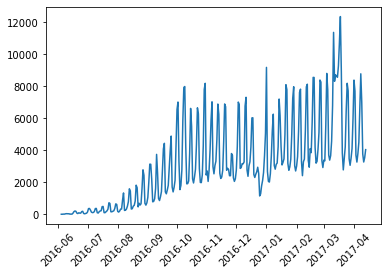

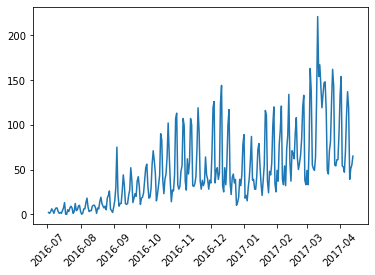

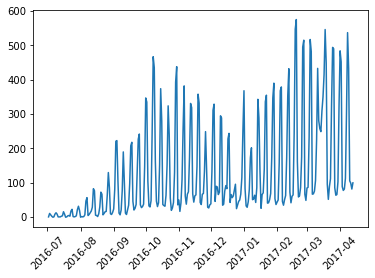

In [6]:
for cat in df['car_category'].unique():
    df_cat = df[df['car_category'] == cat]
    fig, ax = plt.subplots()
    plt.plot(df_cat['date'], df_cat['rides'])
    ax.xaxis.set_major_locator(matplotlib.dates.MonthLocator())
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%Y-%m"))
    plt.xticks(rotation=45)
    plt.show()

# Forecasting

## Reduce to 1 category, univariate

In [7]:
prophet_df = df[df['car_category'] == 'REGULAR'][['date', 'rides']].rename(columns={'date': 'ds', 'rides': 'y'})

disp(prophet_df)

(314, 2)


,ds,y
0,2016-06-04,5.0
1,2016-06-05,5.0
2,2016-06-06,13.0
3,2016-06-07,10.0
4,2016-06-08,23.0


In [ ]:
# Initialize model
m = Prophet(growth='linear', seasonality_mode='multiplicative', weekly_seasonality=True)
m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
m.add_country_holidays(country_name='US')
holiday_cols = ['Christmas Day', 'Columbus Day', 'Independence Day', 'Independence Day (Observed)', 'Labor Day', 
                'Martin Luther King Jr. Day', 'Memorial Day', "New Year's Day", 'Thanksgiving', 'Veterans Day', 
                'Veterans Day (Observed)', "Washington's Birthday"]
holiday_df = pd.DataFrame({'holiday': holiday_cols, 'effect': np.nan})

horizon = 30
m.fit(prophet_df)
# future = m.make_future_dataframe(periods=horizon, freq='D')
# pred = m.predict(future)

# fig = m.plot(pred);
# m.plot_components(pred);

# print(f'Time: {time.time() - start_time}')
# print(f'\nHoliday Effects')
# for col in holiday_cols:
#     print(f'\t{col}: {round(abs(pred[col]).max(), 1)}')



INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
